# 0. Imports

In [49]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import inflection
import pickle
import re
import s3fs
import umap.umap_ as umap
import warnings
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor
from plotly import express as px

path = 'C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\insiders-loyality-program-clustering\\'
SEED = 42

## 0.2 Loading Data

In [2]:
#load data in S3 
path_s3 = 's3://insiders-s3/'

df_raw = pd.read_csv(path_s3+'Ecommerce.csv', encoding='ISO-8859-1')

#drop undesired column
df_raw = df_raw.drop(columns='Unnamed: 8')

# 1. Data Description

In [3]:
df1 = df_raw.copy()

## 1.0 Rename Columns

In [4]:
#transforming to columns to snake_case 
new_cols=[]

for col in df1.columns:
    new_cols.append(inflection.underscore(col))  
    
df1.columns = new_cols 

## 1.1 Data Dimensions

In [5]:
print('The dataset has {} rows'.format(df1.shape[0]))
print('The dataset has {} attributes'.format(df1.shape[1]))

The dataset has 541909 rows
The dataset has 8 attributes


## 1.2 Check NAs

In [6]:
df1.isna().sum()*100 / df1.shape[0]

invoice_no       0.000000
stock_code       0.000000
description      0.268311
quantity         0.000000
invoice_date     0.000000
unit_price       0.000000
customer_id     24.926694
country          0.000000
dtype: float64

### 1.2.1 Adjust NAs

In [7]:
#getting unique invoice_no to missing customer_id 
df_missing = df1[df1['customer_id'].isna()].drop_duplicates(subset='invoice_no')

#setting new customer_id's
df_missing['new_customer_id'] = np.arange(19000, 19000+len(df_missing),1)

#combining back new ids
df1 = pd.merge(df1, df_missing[['invoice_no','new_customer_id']], on='invoice_no', how='left')
df1['customer_id'] = df1['customer_id'].combine_first(df1['new_customer_id'])

#dropping derived column
df1 = df1.drop(columns='new_customer_id')

In [8]:
df1.isna().sum() *100  / df1.shape[0]

invoice_no      0.000000
stock_code      0.000000
description     0.268311
quantity        0.000000
invoice_date    0.000000
unit_price      0.000000
customer_id     0.000000
country         0.000000
dtype: float64

## 1.3 Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.3.1 Adjust Data Types

In [10]:
#invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype('int')

In [11]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

# 2. Descriptive Statistics

In [12]:
df2 = df1.copy()

### 2.1 Numerical Attributes

In [13]:
num_att = df2.select_dtypes(include=['int32','int64','float64'])

In [14]:
num_att.agg(["min","max","mean","median","std","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

,features,min,max,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,9.552250,3.00,218.081158,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,4.611114,2.08,96.759853,186.506972,59005.719097
2,customer_id,12346.00,22709.0,16688.840453,16249.00,2911.411352,0.487449,-0.804287


### 2.2 Categorical Attributes

In [15]:
cat_att = df2.select_dtypes(exclude=['int32','int64','float64','datetime64[ns]'])

In [16]:
cat_att.agg(['count','unique']).T.reset_index().rename(columns= {'index' : 'features'})

,features,count,unique
0,invoice_no,541909,"[536365, 536366, 536367, 536368, 536369, 53637..."
1,stock_code,541909,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,..."
2,description,540455,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
3,country,541909,"[United Kingdom, France, Australia, Netherland..."


# 3. Feature Filtering

In [17]:
df3 = df2.copy()

## 3.1 Check Strutural/Business Problems

In [18]:
for i in df3['country'].unique():
    print(i)

United Kingdom
France
Australia
Netherlands
Germany
Norway
EIRE
Switzerland
Spain
Poland
Portugal
Italy
Belgium
Lithuania
Japan
Iceland
Channel Islands
Denmark
Cyprus
Sweden
Austria
Israel
Finland
Bahrain
Greece
Hong Kong
Singapore
Lebanon
United Arab Emirates
Saudi Arabia
Czech Republic
Canada
Unspecified
Brazil
USA
European Community
Malta
RSA


In [19]:
for i in sorted(df3['stock_code'].unique()):
    print(i)

10002
10080
10120
10123C
10123G
10124A
10124G
10125
10133
10134
10135
11001
15030
15034
15036
15039
15044A
15044B
15044C
15044D
15056BL
15056N
15056P
15056bl
15056n
15056p
15058A
15058B
15058C
15060B
15060b
16008
16010
16011
16012
16014
16015
16016
16020C
16033
16043
16045
16046
16048
16049
16052
16053
16054
16151A
16156L
16156S
16161G
16161M
16161P
16161U
16162L
16162M
16168M
16169E
16169K
16169M
16169N
16169P
16202A
16202B
16202E
16206B
16207A
16207B
16216
16218
16219
16225
16235
16236
16237
16238
16244B
16248B
16254
16258A
16259
17001
17003
17007B
17011A
17011F
17012A
17012B
17012C
17012D
17012E
17012F
17013D
17014A
17021
17028J
17038
17084A
17084J
17084N
17084P
17084R
17090A
17090D
17091A
17091J
17096
17107D
17109D
17129F
17136A
17164B
17165D
17174
17191A
18007
18094C
18097A
18097C
18098C
18098c
20615
20616
20617
20618
20619
20622
20652
20653
20654
20655
20657
20658
20659
20661
20662
20663
20664
20665
20666
20667
20668
20669
20670
20671
20674
20675
20676
20677
20678
20679
20681
206

In [20]:
for i in df3['description'].unique():
    print(i)

WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA

In [21]:
#searching for only invoices starting with a letter
df3[df3['invoice_no'].apply(lambda x: re.match('^[A-Z]+', x)).notnull()].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,17548,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2016-11-29,4.25,17897,United Kingdom


In [22]:
#searching for only invoices starting with a letter
df3[df3['stock_code'].apply(lambda x: re.match('^[a-zA-Z]+', x)).notnull()]['stock_code'].unique()

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [23]:
#removing records containing garbage in stock_code
df3 = df3[~df3['stock_code'].isin(['BANK CHARGES', 'C2', 'CRUK', 'B', 'D', 'DOT', 'M', 'm', 'PADS', 'POST','AMAZONFEE','S'])]

In [24]:
#removing unit_prices below 0.04
df3 = df3[df3['unit_price'] >= 0.04]

In [25]:
#European Community and Unspecified are not countries => remove and deal later
df3 = df3[~df3.isin(['European Community','Unspecified'])]

In [26]:
#description is useless feature to this business problem => drop
df3 = df3.drop(columns='description')

In [27]:
#dealing with returned goods (quantity < 0) - split into 2 dataframes
df_returns = df3[df3['quantity'] < 0]
df_purchases = df3[df3['quantity'] > 0]

## 3.2 Check Duplicates / Low Variance

In [28]:
#country => more than 90% from UK (low variance == less information) => drop feature
df3['country'].value_counts(normalize=True).head()*100

United Kingdom    91.680597
Germany            1.696866
France             1.536228
EIRE               1.505817
Spain              0.460271
Name: country, dtype: float64

## 3.3 Check Outliers / Business Knowledge

In [29]:
#bad users - purchased 1x returned total
bad_user_list = [16446, 12346, 13672, 12346, 13762, 18268, 14557,16878, 13364, 14792, 12607, 12454, 18274, 12558]
df3 = df3[~df3['customer_id'].isin(bad_user_list)]

# 4. Feature Engineering

In [30]:
df4 = df3.copy()

In [31]:
#To derivate new features we will use RFM business model
df_ref = df4['customer_id'].drop_duplicates().reset_index(drop=True)

In [32]:
# Monetary - Gross Revenue
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']
df_monetary = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_monetary, on='customer_id',how='left')

In [33]:
#Recency - Days from last purchase (df4['invoice_date'].max() will be considered as 'today')

df_recency = df_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df4['invoice_date'].max() - df_recency['invoice_date']).dt.days

df_ref = pd.merge(df_ref, df_recency[['customer_id','recency_days']], on = 'customer_id', how='left')

In [34]:
# Qty Invoices Purchased - How  many times purchased
df_qty = df_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_qty.columns.values[1] = 'qty_invoices'

df_ref = pd.merge(df_ref, df_qty[['customer_id','qty_invoices']], on='customer_id', how='left')

In [35]:
# Qty Total Purchased - Sum of items purchased
df_qty_items = df_purchases[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_qty_items.columns.values[1] = 'qty_items_purchased'

df_ref = pd.merge(df_ref, df_qty_items[['customer_id','qty_items_purchased']], on='customer_id', how='left')

In [36]:
# Variety Products Purchased - Count of items purchased
df_variety_prods = df_purchases[['customer_id', 'stock_code']].drop_duplicates().groupby('customer_id').count().reset_index()
df_variety_prods.columns.values[1] = 'products_variety'

df_ref = pd.merge(df_ref, df_variety_prods[['customer_id','products_variety']], on='customer_id', how='left')

In [37]:
# Avg Ticket Value
df_avg_ticket = df_purchases[['gross_revenue','customer_id']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket[['customer_id','avg_ticket']], on='customer_id',how='left')

In [38]:
#Frequency - time elapsed between purchases on a customer 'purchase window'
df_freq = (df_purchases[['customer_id','invoice_date','invoice_no']].drop_duplicates()
                                                                   .groupby('customer_id')
                                                                   .agg(days = ('invoice_date', lambda x: ((x.max()-x.min()).days)+1),
                                                                        ttl_purchases = ('invoice_no','count'))).reset_index()


df_freq['frequency_days'] = df_freq.apply(lambda x: x['days']/x['ttl_purchases'], axis=1) 
df_ref = pd.merge(df_ref, df_freq[['customer_id','frequency_days']], on='customer_id', how='left')

In [39]:
#Tot Items Returned
df_ttl_returns = df_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_ttl_returns.columns.values[1] = 'total_return'

df_ref = pd.merge(df_ref, df_ttl_returns, on='customer_id', how='left')
df_ref['total_return'] = df_ref['total_return']*-1
df_ref['total_return'] = df_ref['total_return'].fillna(0)

In [40]:
#Average Basket size - Avg of qty products by invoice
df_basket_size = (df_purchases[['customer_id', 'invoice_no', 'stock_code', 'quantity']].groupby('customer_id')
                                                                                 .agg(n_purchases=('invoice_no','nunique'),
                                                                                      qty_products=('quantity','sum'))
                                                                                 .reset_index())

df_basket_size['avg_basket_size'] = df_basket_size['qty_products'] / df_basket_size['n_purchases']

df_ref = pd.merge(df_ref, df_basket_size[['customer_id','avg_basket_size']], on='customer_id', how='left' )

In [41]:
#Basket size variety - avg diff products purchased
df_basket_uniq = (df_purchases[['customer_id', 'invoice_no', 'stock_code', 'quantity']].groupby('customer_id')
                                                                                 .agg(n_purchases=('invoice_no','nunique'),
                                                                                      n_products=('stock_code','nunique'))
                                                                                 .reset_index())

df_basket_uniq['avg_variety_basket'] = df_basket_uniq['n_products'] / df_basket_uniq['n_purchases']

df_ref = pd.merge(df_ref, df_basket_uniq[['customer_id','avg_variety_basket']], on='customer_id', how='left' )

In [42]:
# Mean price unit
df_prices = df_purchases[['customer_id','unit_price']].groupby('customer_id').mean().reset_index().rename(columns={'unit_price':'avg_unit_price'})
df_ref = pd.merge(df_ref, df_prices, on='customer_id', how='left' )

In [43]:
# reshaping distributions
df_ref['gross_revenue'] = np.log(df_ref['gross_revenue'])
df_ref['recency_days'] = np.sqrt(df_ref['recency_days'])
df_ref['qty_items_purchased'] = np.log(df_ref['qty_items_purchased'])
df_ref['products_variety'] = np.cbrt(df_ref['products_variety'])
df_ref['avg_ticket'] = np.log(df_ref['avg_ticket'])
df_ref['frequency_days'] = np.sqrt(df_ref['frequency_days'])
df_ref['avg_basket_size'] = np.cbrt(df_ref['avg_basket_size'])
df_ref['avg_variety_basket'] = np.cbrt(df_ref['avg_variety_basket'])
df_ref['avg_unit_price'] = np.log(df_ref['avg_unit_price'])

In [44]:
#dropping records w/ NAs generated in feature engineering => will be investigated later
df_ref = df_ref.dropna()

In [45]:
df_ref.isna().sum()

customer_id            0
gross_revenue          0
recency_days           0
qty_invoices           0
qty_items_purchased    0
products_variety       0
avg_ticket             0
frequency_days         0
total_return           0
avg_basket_size        0
avg_variety_basket     0
avg_unit_price         0
dtype: int64

# 5. Exploratory Data Analysis

In [46]:
df5 = df_ref.copy()

## 5.3 Data Space Investigation

### 5.3.4 Tree Based Embedding

In [47]:
# X_emb = df53.drop(columns='gross_revenue', axis=1)
# y = df53['gross_revenue'] 

cols_selected_tree = [
                      'recency_days', 
                      'qty_invoices',
                      'products_variety',
                      'avg_ticket',
                      'frequency_days',
                      'total_return',
                      'avg_basket_size',
                      'avg_unit_price'
                     ]


X_emb = df5[cols_selected_tree]
y = df5['gross_revenue']

# # model definition
# rf = RandomForestRegressor(n_estimators=300, random_state=SEED)

# # model training
# rf.fit(X_emb,y)

# # saving embedding in pickle
# with open(path+'src\\models\\embedding.pkl','wb') as embedding_pickled:
#     pickle.dump(rf, embedding_pickled)

In [50]:
AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
fs = s3fs.S3FileSystem(anon=False, key=AWS_ACCESS_KEY_ID, secret=AWS_SECRET_ACCESS_KEY)

In [51]:
# loading embedding in pickle
with fs.open(path_s3+'embedding.pkl','rb') as embedding_pickled:
    rf = pickle.load(embedding_pickled)

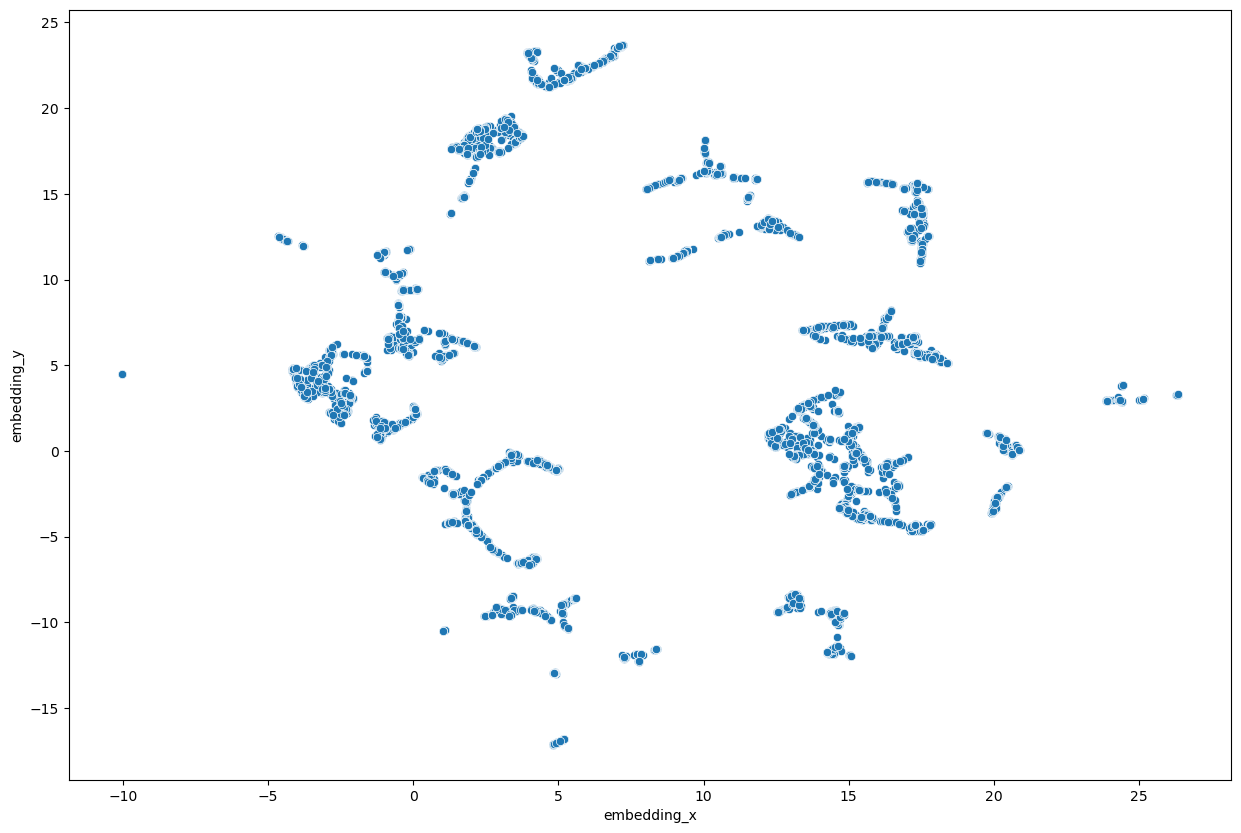

In [52]:
# dataframe leaves - tree-based embedding
df_leaf = pd.DataFrame(rf.apply(X_emb))

#instantiate a space reducer
reducer = umap.UMAP(random_state=SEED)

#create a embedding space
embedding_rf = reducer.fit_transform(df_leaf)

df_tree = pd.DataFrame(embedding_rf, columns=['embedding_x','embedding_y'])


#plot high dimensional space into 2d 
plt.figure(figsize=(15,10))
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 9. ML Modeling

In [53]:
X = df_tree.copy()   #embedding space

## 9.6 Final Model

In [54]:
# #cluster number definition - here is important to consider not only SS but business application (i.e, we can't pick high k which we couldnt explain customer behaviour)
# k = 9 #embedding space

# #model definition
# gmm = GaussianMixture(init_params='k-means++',n_components=k,n_init=300, max_iter=100)

# #model training
# gmm.fit(X)

# loading model in pickle
with fs.open(path_s3+'gmm_pickled.pkl','rb') as model_pickled:
    gmm = pickle.load(model_pickled)

#clustering                                                                                               
labels = gmm.predict(X)
                                                                                                
#model performance
sil_score = metrics.silhouette_score(X, labels, metric='euclidean')
print('Final Sillhouete Score: {:.2f}'.format(sil_score))

Final Sillhouete Score: 0.55


In [ ]:
# # saving model in pickle
# with open(path+'src\\models\\gmm_pickled.pkl','wb') as model_pickled:
#     pickle.dump(gmm, model_pickled)

# 10. Cluster Analysis

In [55]:
df_viz = X.copy()

#cluster attribution
df_viz['cluster'] = labels

## 10.1 Visual Inspection

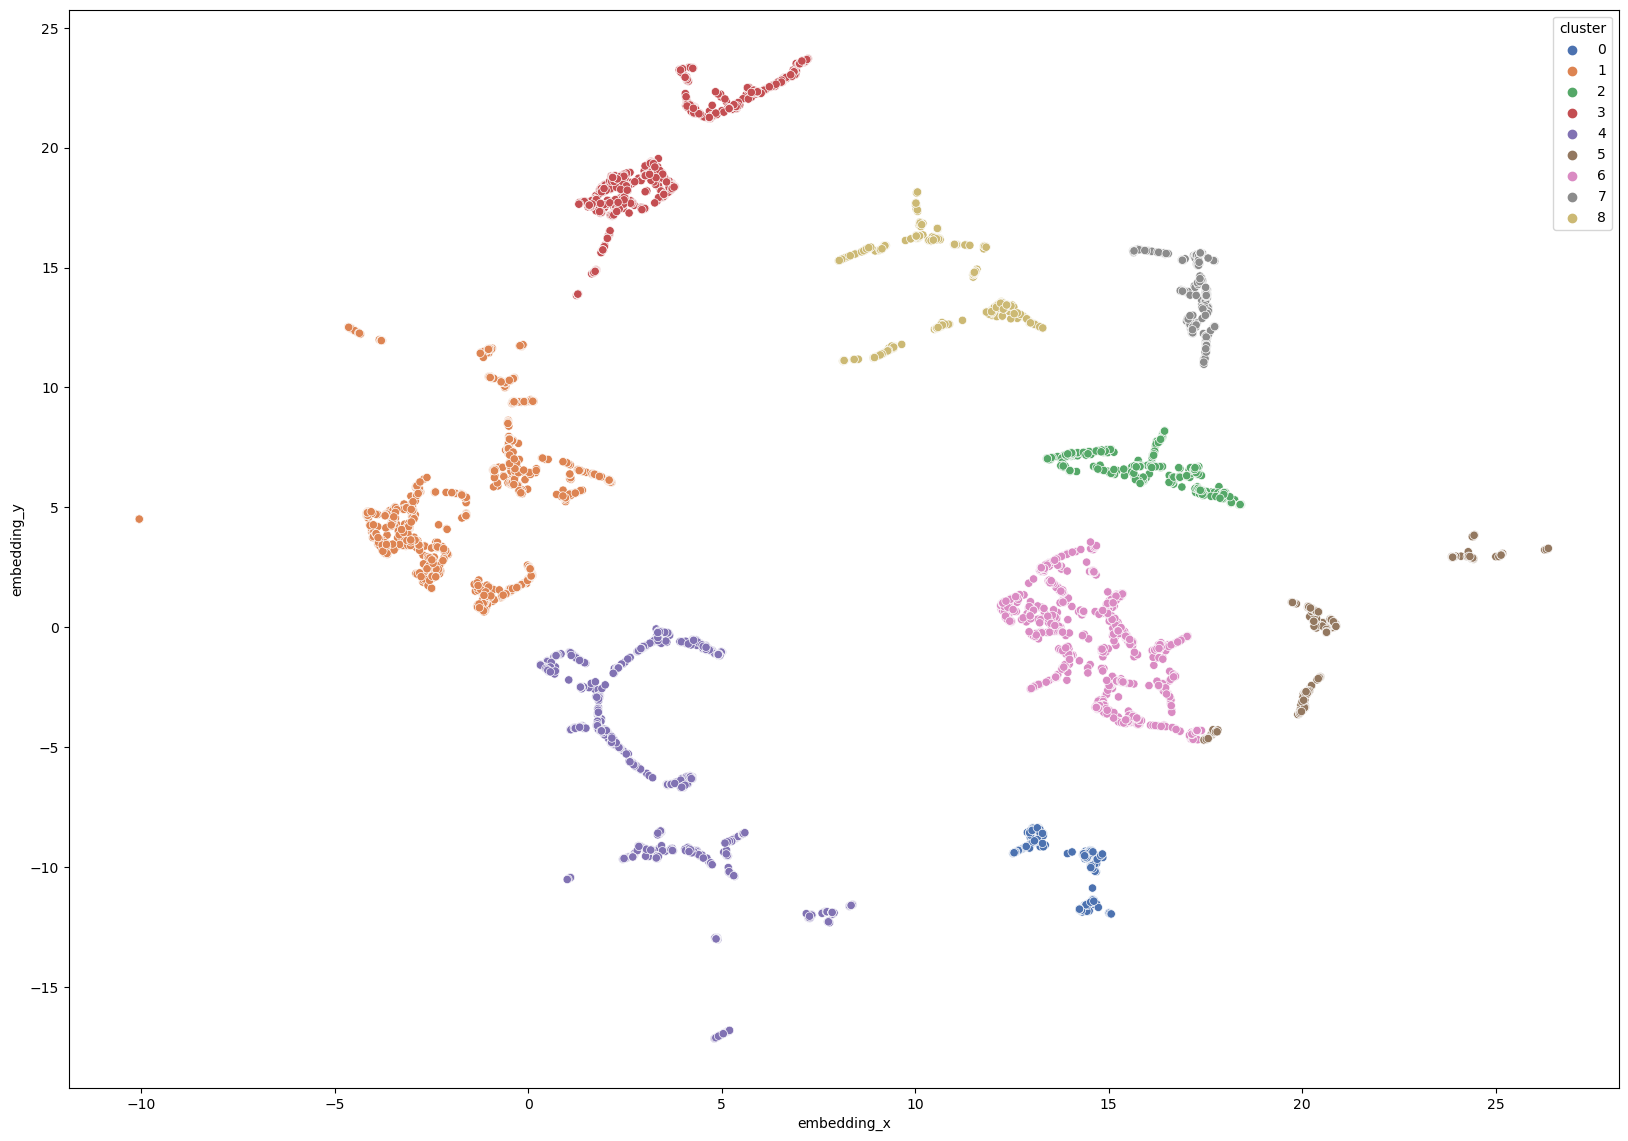

In [56]:
#plot high dimensional space into 2d 
plt.figure(figsize=(20,14))

#plot high dimensional space into 2d 
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette='deep', data=df_viz);

## 10.3 Cluster Profile

In [57]:
df10 = df5[cols_selected_tree].copy()
df10[['gross_revenue','customer_id']] = df5[['gross_revenue','customer_id']].copy()
df10['cluster'] = labels

In [58]:
# shaping back distributions
df10['gross_revenue'] = np.exp(df_ref['gross_revenue'])
df10['recency_days'] = (df_ref['recency_days'])**2
df10['products_variety'] = (df_ref['products_variety'])**3
df10['avg_ticket'] = np.exp(df_ref['avg_ticket'])
df10['frequency_days'] = (df_ref['frequency_days'])**2
df10['avg_basket_size'] = (df_ref['avg_basket_size'])**3
df10['avg_unit_price'] = np.exp(df_ref['avg_unit_price'])

In [59]:
#Number of Customers
df_cluster = df10[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id':'qty_customers'})
df_cluster['perc_customers'] = (df_cluster['qty_customers'] / df_cluster['qty_customers'].sum())*100

# Average Gross Revenue
df_gr = df10[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'gross_revenue':'avg_revenue'})
df_cluster = pd.merge(df_cluster,df_gr, on='cluster', how='inner')
 
#Average Recency
df_rec = df10[['recency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'recency_days':'avg_recency'})
df_cluster = pd.merge(df_cluster,df_rec, on='cluster', how='inner')

# Average Products Variety
df_var = df10[['products_variety', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'products_variety':'avg_variety'})
df_cluster = pd.merge(df_cluster,df_var, on='cluster', how='inner')

# Average Frequency
df_fre = df10[['frequency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'frequency_days':'avg_frequency'})
df_cluster = pd.merge(df_cluster,df_fre, on='cluster', how='inner') 

#Average Total Return
df_ret = df10[['total_return', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'total_return':'avg_returns'})
df_cluster = pd.merge(df_cluster,df_ret, on='cluster', how='inner') 

#Average Price Unit
df_price = df10[['avg_unit_price', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_price, on='cluster', how='inner') 

#Average Basket Size
df_basket = df10[['avg_basket_size', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_basket, on='cluster', how='inner') 

#Average Ticket
df_ticket = df10[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_ticket, on='cluster', how='inner') 

#Qty Invoices
df_invo = df10[['qty_invoices', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'qty_invoices':'avg_invoices'})
df_cluster = pd.merge(df_cluster,df_invo, on='cluster', how='inner') 

#reordering
df_cluster = df_cluster[['cluster','qty_customers','perc_customers','avg_revenue','avg_ticket','avg_unit_price','avg_basket_size','avg_invoices','avg_variety','avg_recency','avg_frequency','avg_returns']]

df_cluster.sort_values(by='avg_revenue', ascending=False)

,cluster,qty_customers,perc_customers,avg_revenue,avg_ticket,avg_unit_price,avg_basket_size,avg_invoices,avg_variety,avg_recency,avg_frequency,avg_returns
0,0,279,4.901616,12952.705018,32.163428,2.931530,302.740437,21.189964,217.082437,13.290323,20.244986,98.347670
5,5,345,6.061138,2994.662058,17.871625,3.533633,641.603330,4.295652,204.739130,89.284058,23.704311,13.069565
7,7,350,6.148981,2892.389543,63.234729,3.371029,209.087414,6.568571,29.331429,49.334286,43.326955,85.140000
6,6,987,17.340126,2326.694813,17.676687,3.626105,393.356544,3.684904,118.958460,92.032421,32.854401,13.901722
8,8,493,8.661279,1460.582434,73.322984,4.220094,213.273213,3.576065,38.572008,84.576065,44.597303,32.275862
2,2,437,7.677442,1006.759565,5.307914,2.860088,281.650283,2.562929,159.386728,96.958810,32.197110,1.892449
3,3,730,12.825018,644.141233,56.761125,2.500293,379.487671,1.278082,25.795890,122.927397,16.161644,7.776712
1,1,1160,20.379480,314.433267,24.251082,4.084351,97.211063,1.325862,20.400000,157.915517,20.172845,1.814655
4,4,911,16.004919,75.426564,15.951739,4.789595,29.850048,1.178924,7.670692,182.118551,3.675093,0.158068


## Clusters Reports - Based on Embedding Space - Silhouette Score = 0.55 (GMM)

### Cluster Stark (Insiders Eligible):
        - Customers Quantity: 279 customers (4.9% of total)
        - Gross Revenue: $ 12952
        - Ticket: $ 32
        - Products Price: $2.93
        - Basket Size: 302 un
        - Qty Invoices: 21 purchases
        - Products Variety: 217 products       
        - Time since last purchase: 13 days
        - Time between purchases: 20 days
        - Returns: 98 units

### Cluster Targeryen:
        - Customers Quantity: 345 customers (6% of total)
        - Gross Revenue: $ 2995
        - Ticket: $ 18
        - Products Price: $3.53
        - Basket Size: 641 un
        - Qty Invoices: 4 purchases
        - Products Variety: 204 products       
        - Time since last purchase: 89 days
        - Time between purchases: 23 days
        - Returns: 13 units

### Cluster Lannister: 
        - Customers Quantity: 350 customers (6% of total)
        - Gross Revenue: $ 2892
        - Ticket: $ 63
        - Products Price: $3.37
        - Basket Size: 209 un
        - Qty Invoices: 6 purchases
        - Products Variety: 29 products        
        - Time since last purchase: 49 days
        - Time between purchases: 43 days
        - Returns: 85 units

### Cluster Greyjoy: 
        - Customers Quantity: 987 customers (17% of total)
        - Gross Revenue: $ 2326
        - Ticket: $ 18
        - Products Price: $3.63
        - Basket Size: 393 un
        - Qty Invoices: 3 purchases
        - Products Variety: 118 products        
        - Time since last purchase: 92 days
        - Time between purchases: Every 33 
        - Returns: 14 units
        
### Cluster Baratheon:
        - Customers Quantity: 493 customers (9% of total)
        - Gross Revenue: $ 1460
        - Ticket: $ 73
        - Products Price: $4.22
        - Basket Size: 213 un
        - Qty Invoices: 3 purchases
        - Products Variety: 38 products       
        - Time since last purchase: 84 days
        - Time between purchases: 44 days
        - Returns: 32 units
        


### Cluster Tully: 
        - Customers Quantity: 437 customers (8% of total)
        - Gross Revenue: $ 1006
        - Ticket: $ 5
        - Products Price: $2.86
        - Basket Size: 281 units
        - Qty Invoices: 3 purchases
        - Products Variety: 159 products purchased       
        - Time since last purchase: 97 days
        - Time between purchases: 32 days
        - Returns: 2 units
        
### Cluster Martell: 
        - Customers Quantity: 730 customers (13% of total)
        - Gross Revenue: $ 644
        - Ticket: $ 56
        - Products Price: $2.50
        - Basket Size: 379 units
        - Qty Invoices: 2 purchases
        - Products Variety: 25 products        
        - Time since last purchase: 122 days
        - Time between purchasesequency: 18 days
        - Returns: 7 units
        
### Cluster Arryn: 
        - Customers Quantity: 1160 customers (20% of total)
        - Gross Revenue: $ 315
        - Ticket: $ 24
        - Products Price: $ 4.08
        - Basket Size: 97 units
        - Qty Invoices: 2 purchases
        - Products Variety: 20 products       
        - Time since last purchase: 157 days 
        - Time between purchasesequency: 20 days
        - Returns: 1 units
        
### Cluster Mormont: 
        - Customers Quantity: 911 customers (16% of total)
        - Gross Revenue: $ 75
        - Ticket: $ 16
        - Products Price: $ 4.79
        - Basket Size: 30 units
        - Qty Invoices: 1 purchases
        - Products Variety: 7 products        
        - Time since last purchase: 182 days 
        - Time between purchasesequency:  3 days
        - Returns: 0 units

# 11. Exploratory Data Analysis - Clustering  Focused 

In [60]:
df11 = df10.copy()

## 11.1 Mindmap Hypothesis

In [ ]:
#Image('C:/Users/marco/OneDrive/Documents/repos/ds_em_producao/insiders-loyality-program-clustering/reports/figures/Customer_Loyality_Program_Clustering.png',width=800,height=400)

## 11.2 Hipóteses de Negócio

### Purchases

H0. Os clientes do cluster Stark compram 80% das vezes com cartão de crédito

**H1. Os clientes do cluster Stark compram uma variedade média de produtos duas vezes maior que a média da base de clientes**

H2. Os clientes do cluster Stark possuem 10% de ticket médio acima do cluster Targeryen - 2nd 

H3. Os clientes do cluster Stark possuem um basket size acima de 5 produtos - 2nd 

**H4. Os clientes do cluster Stark possuem um volume de compra (faturamento) acima do 15% do total de compras**

**H5. Os clientes do cluster Stark possuem um número médio de devoluções 20% abaixo da média do restante dos clusters**

**H6. Os clientes do cluster Stark voltam a comprar em média na metade do tempo que a média geral de clientes**

### Customers

H7. 10% dos clientes do cluster Stark estão na faixa 25-35 anos

H8. 40% das localidades de entrega do cluster Stark estão dentro de um raio de 50km - 2nd 

H9. 5% dos clientes do cluster Stark recebem mais de 100k dolares por ano

H10. 90% dos clientes do cluster Stark possuem Ensino Médio

H11. 60% dos clientes do cluster Stark possuem estado civil solteiro

### Products

H12. A média dos preços dos produtos comprados pelo cluster Stark é 10% do que a mediana do restante dos clusters

H13. O peso médio dos produtos comprados pelo cluster Stark é maior que o peso médio do restante dos clusters

H14. Os clientes do cluster Stark compram 40% mais de produtos lançamentos (<90 dias) que o restante dos clusters

H15. Os clientes do cluster Stark compram produtos com maiores markups do que o restante dos clusters

### 11.2.1 Hypothesis Priorization

<h4><font color='red'>Insight and actionable? Data in-house?</h4></font>

**H1. Os clientes do cluster Stark compram uma variedade média de produtos duas vezes maior que a média do total da base de clientes**

**H4. Os clientes do cluster Stark possuem um volume de compra (faturamento) acima do 15% do total de compras**

**H5. Os clientes do cluster Stark possuem um número médio de devoluções 20% abaixo da média do restante dos clusters**

**H6. Os clientes do cluster Stark voltam a comprar em média na metade do tempo que a média geral de clientes**

- Hypothesis H2/H3/H8/H12 we have data in initial dataset, but we didnt use to clustering => we will leave to another moment if business want it
- The remaining hypothesis we don't have data and will evaluate later

## 11.3 Hypothesis Validation

**H1. Os clientes do cluster Stark compram uma variedade média de produtos duas vezes maior que a média da base de clientes**

**True** The Stark Cluster purchases 2,1x more variety

In [ ]:
dif_variety = ((df11[df11['cluster']==0]['products_variety']).mean()/df11['products_variety'].mean()-1)
print('The Stark cluster purchases {:.2f} times more varied products than the whole customers database'.format(dif_variety))

**H4. Os clientes do cluster Stark possuem um volume de compra (faturamento) acima do 15% do total de compras**

**True:** The Stark cluster represents 36% of total revenue

In [ ]:
dif_gr = ((df11[df11['cluster']==0]['gross_revenue']).sum()/df11['gross_revenue'].sum())
print('The Stark cluster represents {:.2f}% of total revenue'.format(dif_gr*100))

**H5. Os clientes do cluster Stark possuem um número médio de devoluções 20% abaixo da média do restante dos clusters**

**False**: Only Cluster Stark return almost 5x more, on average, than all customers returns

In [ ]:
dif_ret = ((df11[df11['cluster']==0]['total_return']).mean() / (df11['total_return']).mean() )-1
print('The Stark cluster return their purchases {:.2f} times more than the whole customers database'.format(dif_ret))

**H6. Os clientes do cluster Stark voltam a comprar em média na metade do tempo que a média geral de clientes**

**False**: The cluster Stark on average have almost the same frequency than the rest of customers

In [ ]:
dif_freq =  ((df11[df11['cluster']==0]['frequency_days']).mean() / (df11['frequency_days']).mean() )
print('The Stark cluster back to purchase {:.2f} times faster than the whole customers database'.format(1/dif_freq))

## 11.4 Hypothesis Board

## 11.5 Business Answers

- Who are the customers elegible?

In [ ]:
print('The customers identified below are Insiders elegible: \n\n{}'.format(sorted(df11[df11['cluster']==0]['customer_id'].to_list())))

- How many customers will be part of Insiders group?

In [ ]:
print('Insiders Loyality Program members qty is {:.0f} - {:.2f}% of total'.format(df11[df11['cluster']==3]['customer_id'].count(),df11[df11['cluster']==0]['customer_id'].count()/df11.shape[0]*100 ))

- What are the main behaviour of those customers?

    - Customers Quantity: 279 customers (4.9% of total)
    - Gross Revenue: $ 12952
    - Ticket: $ 32
    - Products Price: $2.93
    - Basket Size: 302 un
    - Qty Invoices: 21 purchases
    - Products Variety: 217 products       
    - Time since last purchase: 13 days
    - Time between purchases: 20 days
    - Returns: 98 units
    
    - High gross revenue
    - Medium Ticket and Basket Size, 
    - High Products Variety
    - High number of purchases
    - Low range products price 
    - Low recency (last purchase from 'today')
    - Low time between purchases
    - High qty returned Items

- How much revenue comes from Insiders customer groups?

In [ ]:
print('Total from Insiders Loyality Program is $ {:.2f} which means {:.2f}% of total'.format(df11[df11['cluster']==8]['gross_revenue'].sum(),100*(df11[df11['cluster']==0]['gross_revenue'].sum()/df11['gross_revenue'].sum()) ))

- How much revenue is expected from Insiders next month?

    - We need Time Series here, will be delivered next cycle

- Which conditions one person must comply to be an Insider? What removes a customer from Insider group?

    - Who defines it will be the clustering model that we created. Everytime we (re)train the model, we will mark the customer in time and follow if still in loyality program or not. Here is possible to create a policy after X periods out of insiders list customer must be removed (TBD).

- What guarantees the loyality program customers are better than others?

TBD

- Which actions MKT team could take to increase revenue?

Some examples of offers/action that could be taken:
- To Stark Cluster (Insiders):

    - 1) Offer exclusive products with more added value in order to increase avg ticket and avg unit price.
    
    - 2) Offer a kind of direct consultancy/real-time assistant in order to reduce returns
    
    
- To Targeryen:
    - Offer monthly cupons in order to increase the awareness and awake the buying power since this cluster purchases have high basket size but low recency/qty invoices


- To Lannister: 
    - Offer product cross-sell in order to increase product variety since ticket, recency and frequency are ok
- Etc

# 12. Model Deployment

In [61]:
df12 = df11.copy()

## 12.1.1 Insert SQLite

In [62]:
df12.shape

(5692, 11)

In [63]:
#adjusting data types to db
df12['recency_days'] = df12['recency_days'].astype('int')
df12['qty_invoices'] = df12['qty_invoices'].astype('int')
df12['products_variety'] = df12['products_variety'].astype('int')
df12['frequency_days'] = df12['frequency_days'].astype('int')
df12['total_return'] = df12['total_return'].astype('int')
df12['avg_basket_size'] = df12['avg_basket_size'].astype('int')
df12['products_variety'] = df12['products_variety'].astype('int')
df12['cluster'] = df12['cluster'].astype('int')

In [64]:
df12.dtypes

recency_days          int32
qty_invoices          int32
products_variety      int32
avg_ticket          float64
frequency_days        int32
total_return          int32
avg_basket_size       int32
avg_unit_price      float64
gross_revenue       float64
customer_id           int32
cluster               int32
dtype: object

In [ ]:
def query_db(query):
    with sqlite3.connect("insiders_db.sqlite") as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        return cursor.fetchall()

In [ ]:
# #create table
# query_create_table = """
#     CREATE TABLE insiders(
#         recency_days          INTEGER,
#         qty_invoices          INTEGER,
#         products_variety      INTEGER,
#         avg_ticket            REAL,
#         frequency_days        INTEGER,
#         total_return          INTEGER,
#         avg_basket_size       INTEGER,
#         avg_unit_price        REAL,
#         gross_revenue         REAL,
#         customer_id           INTEGER,
#         cluster               INTEGER

#     )

# """

# #drop table
# query_drop_table = """
#     DROP TABLE insiders
# """

# query_db(query_drop_table)
# query_db(query_create_table)

In [67]:
#local endpoint
#endpoint = "sqlite:///insiders_db.sqlite"

# creating endpoint to AWS RDS
host = os.environ.get('HOST')
port = os.environ.get('PORT')
database = os.environ.get('DATABASE')
user = os.environ.get('USER')
pwd = os.environ.get('PASSWORD')

endpoint='postgresql://{}:{}@{}:{}/{}'.format(user,pwd,host,port,database)

conn = create_engine(endpoint)

None


In [ ]:
#insert data 
df12.to_sql('insiders',con=conn, if_exists='append',index=False)

In [ ]:
#select data
query_get_data = """
    SELECT * FROM public.insiders"""

data = pd.read_sql_query(query_get_data, con=conn)

In [ ]:
data.head()